<a href="https://colab.research.google.com/github/Kinexity/light-ML/blob/main/Tlight_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.colab import drive
from scipy.stats import gaussian_kde
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing dataset for nrows events:
dataset_main=pd.read_csv("/content/drive/My Drive/ML_light/source_24Na.csv.gzip", compression="gzip")
dataset_main_Na=pd.read_csv("/content/drive/My Drive/ML_light/source_60Co.csv.gzip", compression="gzip")

In [3]:
def bucket_data(dataframe, number):
    ninth_column = dataframe.iloc[:, 8]

    # Finding the minimum and maximum values of the ninth column
    min_val = ninth_column.min()
    max_val = ninth_column.max()

    # Calculating the width of each bucket
    bucket_width = (max_val - min_val) / number

    # Creating the buckets
    buckets = [min_val + i * bucket_width for i in range(number)] + [max_val]

    # Bucketing the data based on the ninth column
    dataframe['Bucket'] = pd.cut(ninth_column, bins=buckets, labels=False)

    buckets_list = [group for _, group in dataframe.groupby('Bucket')]

    buckets_dict = {np.average(group[" sum"].to_numpy()):group for group in buckets_list}

    buckets_list = list(buckets_dict.values())

    # Finding the index of the dataframe with the most elements
    index_of_max_elements = max(range(len(buckets_list)), key=lambda i: len(buckets_list[i]))

    buckets_list_subset = buckets_list[int(index_of_max_elements*0.1):index_of_max_elements]

    min_elements = min([len(df) for df in buckets_list_subset])

    buckets_list = [(df if len(df) <= min_elements else df.sample(min_elements + int(min_elements * np.log(len(df)/min_elements)))) for df in buckets_list]

    return pd.concat(buckets_list)

In [4]:
def replace_random_elements_with_minus_one(df):
    num_rows, num_cols = df.shape

    array_with_sequence = np.arange(0, num_cols - 1)

    np.random.default_rng().shuffle(array_with_sequence)

    for i in range(num_rows):
        df.iloc[i, array_with_sequence[:3]] = -1
        np.random.default_rng().shuffle(array_with_sequence)

    return df

In [5]:
def generate_mask(rows, columns, probability):
    # Generate a random numpy array with True/False values based on the given probability
    mask = np.random.rand(rows, columns - 1) < probability

    # Check if any rows are all True
    while np.any(np.all(mask, axis=1)):
        # Regenerate the problematic rows
        problematic_rows = np.where(np.all(mask, axis=1))[0]
        mask[problematic_rows, :] = np.random.rand(len(problematic_rows), columns - 1) < probability

    mask = np.hstack((mask, np.full((rows, 1), False, dtype=bool)))

    return mask

In [6]:
def replace_random_elements_with_minus_one2(df):
    num_rows, num_cols = df.shape

    mask = generate_mask(num_rows, num_cols, 0.5)


    df_numpy = df.to_numpy()

    np.where(mask, df_numpy, -1)

    return pd.DataFrame(np.where(mask, -1, df_numpy))

In [7]:
#filter the dataset to get more even distribution of sums

dataset_full = dataset_main.copy().sample(1000000)
dataset = replace_random_elements_with_minus_one2(dataset_full)
#dataset = bucket_data(dataset_main.copy(), 1000).sample(1000000)

In [8]:
#filter the dataset to get more even distribution of sums

dataset_full_Na = dataset_main_Na.copy().sample(1000000)
dataset_Na = replace_random_elements_with_minus_one2(dataset_full_Na)
#dataset = bucket_data(dataset_main.copy(), 1000).sample(1000000)

In [9]:
 #Independent variables:
#X=dataset.iloc[:,0:6].values #only 6 PMTs summed, for example. We could also take N PMTS but shuffled randomly for each event, not always the first N ones
X=dataset.iloc[:,:8].values #all PMTs summed
#Dependent variable:
Y=dataset.iloc[:,8].values
Y_full=dataset_full.iloc[:,8].values

In [10]:
 #Independent variables:
#X=dataset.iloc[:,0:6].values #only 6 PMTs summed, for example. We could also take N PMTS but shuffled randomly for each event, not always the first N ones
X_Na=dataset_Na.iloc[:,:8].values #all PMTs summed
#Dependent variable:
Y_Na=dataset_Na.iloc[:,8].values
Y_full_Na=dataset_full.iloc[:,8].values

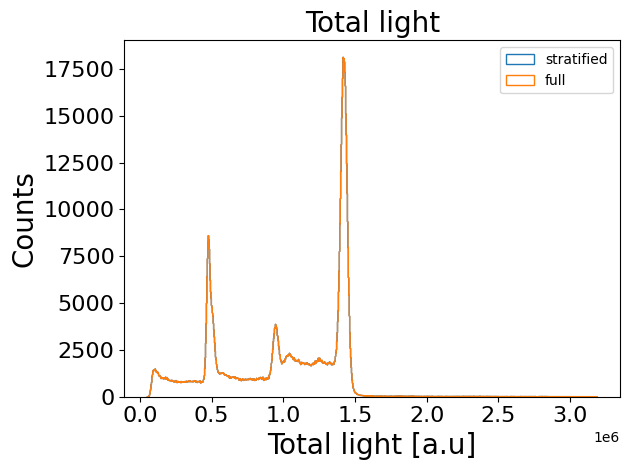

In [11]:
fig, ax = plt.subplots()
nbins = 1000
n, bins, _ = plt.hist(Y, nbins, histtype='step', label = "stratified")#, density = True)
plt.hist(Y_full, nbins, histtype='step', label = "full")#, density = True)
ax.set_title("Total light", fontsize = 20.0)
ax.set_xlabel("Total light [a.u]",fontsize = 20.0)
ax.set_ylabel("Counts", fontsize = 20.0)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Split train and test sets
from sklearn.model_selection import train_test_split
#test_size: always between 0.2 and 0.3 (20-30% to the test set)
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2, shuffle=True, random_state=0)
X_train, X_test, Y_train, Y_test = X_test, X_train, Y_test, Y_train
val_data = (X_test, Y_test)

In [13]:
#Split train and test sets
from sklearn.model_selection import train_test_split
#test_size: always between 0.2 and 0.3 (20-30% to the test set)
X_train_Na, X_test_Na, Y_train_Na, Y_test_Na=train_test_split(X_Na,Y_Na, test_size=0.2, shuffle=True, random_state=0)
X_train_Na, X_test_Na, Y_train_Na, Y_test_Na = X_test_Na, X_train_Na, Y_test_Na, Y_train_Na
val_data_Na = (X_test_Na, Y_test_Na)

In [14]:
#We apply feature scaling
from sklearn.preprocessing import RobustScaler
sc_X=RobustScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

In [15]:
#We apply feature scaling
from sklearn.preprocessing import RobustScaler
sc_X_Na=RobustScaler()
X_train_Na=sc_X_Na.fit_transform(X_train_Na)
X_test_Na=sc_X_Na.transform(X_test_Na)

In [16]:
def shuffle_arrays_in_same_order(array1, array2):
    """
    Shuffle the rows of two 2D NumPy arrays in the same order.

    Parameters:
    - array1: The first 2D NumPy array.
    - array2: The second 2D NumPy array.

    Returns:
    A tuple containing the shuffled arrays.
    """
    # Get the number of rows
    num_rows = array1.shape[0]

    # Generate a random permutation of indices
    random_indices = np.random.permutation(num_rows)

    # Shuffle both arrays using the same order of indices
    shuffled_array1 = array1[random_indices, :]
    shuffled_array2 = array2[random_indices]

    return shuffled_array1, shuffled_array2

In [18]:
print(X_train.shape)
print(X_train_Na.shape)

X_train_ = np.array([])
Y_train_ = np.array([])
X_test_ = np.array([])
Y_test_ = np.array([])

if False:
    X_train_ = np.concatenate((X_train, X_train_Na), axis = 0)
    Y_train_ = np.concatenate((Y_train, Y_train_Na), axis = 0)
    X_test_ = np.concatenate((X_test, X_test_Na), axis = 0)
    Y_test_ = np.concatenate((Y_test, Y_test_Na), axis = 0)
else:
    X_train_ = X_train
    Y_train_ = Y_train
    X_test_ = X_test_Na
    Y_test_ = Y_test_Na

if False:
    X_train_ = X_train
    Y_train_ = Y_train
    X_test_ = X_test
    Y_test_ = Y_test

#Y_train_t = np.concatenate((np.full((len(Y_train)), 0), np.full((len(Y_train)), 1)), axis = 0)
#Y_test_t = np.concatenate((np.full((len(Y_test)), 0), np.full((len(Y_test)), 1)), axis = 0)

#print(Y_train_t.shape)
#print(X_train_.shape)

X_train_, Y_train_ = shuffle_arrays_in_same_order(X_train_, Y_train_)

#Y_test_ = Y_test_t

#X_test_ = np.concatenate((X_test, X_test_Na), axis = 0)

#print(X_test_.shape)
#print(Y_test_.shape)

(200000, 8)
(200000, 8)


In [19]:
#Random forest regression
#Average of the different decision tree predictions
#Non-linear model

from sklearn.ensemble import RandomForestRegressor
#n_estimators: number of trees
regressor=RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X_train_,Y_train_)

RandomForestRegressor(n_estimators=10, random_state=0)

In [20]:
Y_pred=regressor.predict(X_test_)

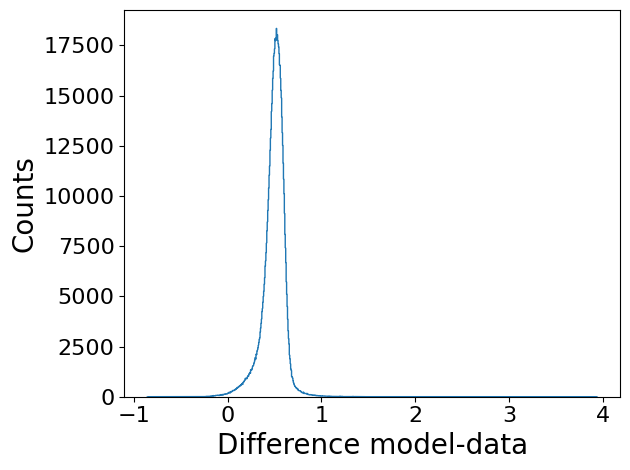

In [21]:
#Evaluation of the performance by calculating diferences between real data and predictions (one could fit the peak with a gaussian and calculate the sigma)
fig, ax = plt.subplots()
nbins = 1000
#print(np.std((Y_pred-Y_test_)/Y_test_))
n, bins, _ = plt.hist((Y_pred-Y_test_)/Y_test_, nbins, histtype='step')
ax.set_xlabel("Difference model-data",fontsize = 20.0)
ax.set_ylabel("Counts", fontsize = 20.0)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.tight_layout()
plt.show()

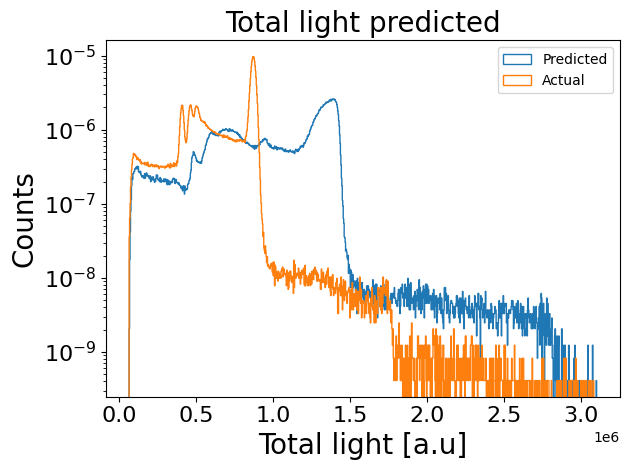

In [22]:
#Plot predicted summed spectrum for test set
fig, ax = plt.subplots()
nbins = 1000
n, bins, _ = plt.hist(Y_pred, nbins, histtype='step', label = "Predicted", density=True)
plt.hist(Y_test_, bins=bins, histtype='step', label = "Actual", density=True)
#plt.hist(Y_test, bins=bins, histtype='step', label = "Actual", density=True)
#print(X_test.)
ax.set_title("Total light predicted", fontsize = 20.0)
ax.set_xlabel("Total light [a.u]",fontsize = 20.0)
ax.set_ylabel("Counts", fontsize = 20.0)
ax.set_yscale("log")
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.legend()
plt.tight_layout()
plt.show()